# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget

import tensorflow as tf
import numpy as np
import os
from utils import *


Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname

fs,x = wav2audio_segment(filename)
S = audio2spectral(x,orig_fs=fs,resample_fs=22050,representation='STFT',units='db',nfft_size= 2**10,
         frame_size=64, n_bins = 64,normalization_axis=None)

Dimensions: data length, freq bins, time bins
185 513 64


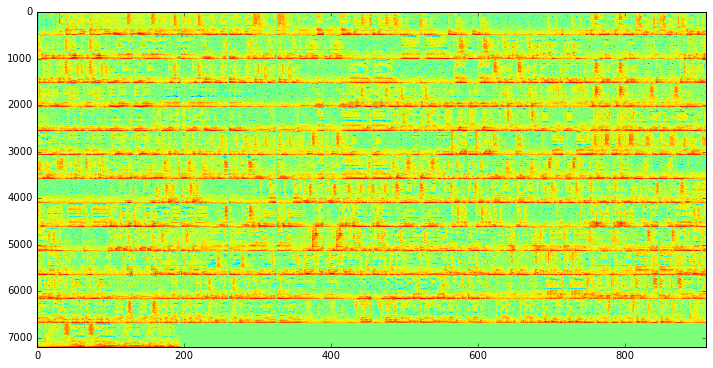

In [3]:
print("Dimensions: data length, freq bins, time bins")
total_length, freq_bins,time_bins = S.shape
print(total_length, freq_bins,time_bins)

# imshow(S[21],aspect='auto',origin='bottom');
figure(figsize=(12,6))
imshow(montage(S),aspect='auto');

In [4]:
train_length = 120
test_length = total_length - train_length
ixs = np.arange(total_length)
np.random.shuffle(ixs)

data = Data( S[ixs[:train_length],:,:].reshape((train_length,freq_bins*time_bins)) )

test = Data( S[ixs[train_length:train_length+test_length],:,:].reshape((test_length,freq_bins*time_bins)) )

In [5]:
mean_img = data.data.mean(0)

batch_size = 60
n_epochs = 300
learning_rate = 0.001
n_filters=[16,16,16]
n_features =  int(data.data.shape[1])
input_shape = [None, n_features]
filter_sizes = [4,4,4]
stri = [1, 2, 2, 1]

In [6]:
input_shape

[None, 32832]

In [7]:
# %%
tf.reset_default_graph()
# input to the network
X = tf.placeholder( tf.float32, input_shape, name='x')

X_tensor = tf.reshape(X, [-1, freq_bins, time_bins, 1])

current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []
l = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

z = current_input
# %%
# store the latent representation
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
l.append(current_input)

# %%
# now have the reconstruction through the network
Y = current_input
Y = tf.reshape(Y, [-1, n_features])
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

ae = {'X': X, 'z': z, 'Y': Y, 'cost': cost}

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 1]]


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 1]]


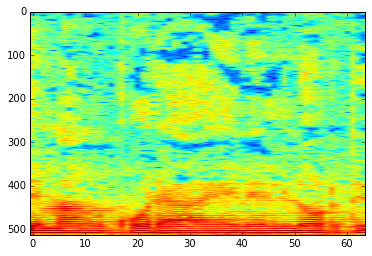

In [8]:
print(n_filters, filter_sizes, shapes)
imshow(data.next_batch(batch_size)[0].reshape((freq_bins,time_bins)),aspect='auto')

In [9]:
# %%
# We create a session to use the graph
config = tf.ConfigProto( device_count = {'GPU': 1} )
sess = tf.Session(config=config)
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={ae['X']: batch_xs-mean_img })
    
    if epoch_i%5==0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['X']: batch_xs-mean_img}))

0 0.0054898
5 0.00540565
10 0.00541862
15 0.00515378
20 0.00534778
25 0.00536323
30 0.00534406
35 0.00530646
40 0.00533001
45 0.00523583
50 0.00463
55 0.00457744
60 0.00446235
65 0.0043414
70 0.0042164
75 0.00411936
80 0.00407669
85 0.00402341
90 0.0040661
95 0.00388682
100 0.00390088
105 0.00390833
110 0.00387488
115 0.00378566
120 0.00378471
125 0.00374835
130 0.00379101
135 0.00378169
140 0.00371732
145 0.00373248
150 0.00376592
155 0.00370037
160 0.00361877
165 0.00368497
170 0.00363639
175 0.00368056
180 0.00356573
185 0.00364306
190 0.00349232
195 0.00355384
200 0.00359868
205 0.00355238
210 0.00354578
215 0.00350401
220 0.00360184
225 0.00345037
230 0.00357698
235 0.00356672
240 0.00355595
245 0.00358549
250 0.00354541
255 0.00357229
260 0.00361303
265 0.00347437
270 0.00351807
275 0.00348135
280 0.00352173
285 0.00349672
290 0.00343187
295 0.00346157


In [14]:
compare = [3,21,46]

recon = sess.run(ae['Y'], feed_dict={ ae['X']: data.data[compare]-mean_img})

recon.shape

(3, 32832)

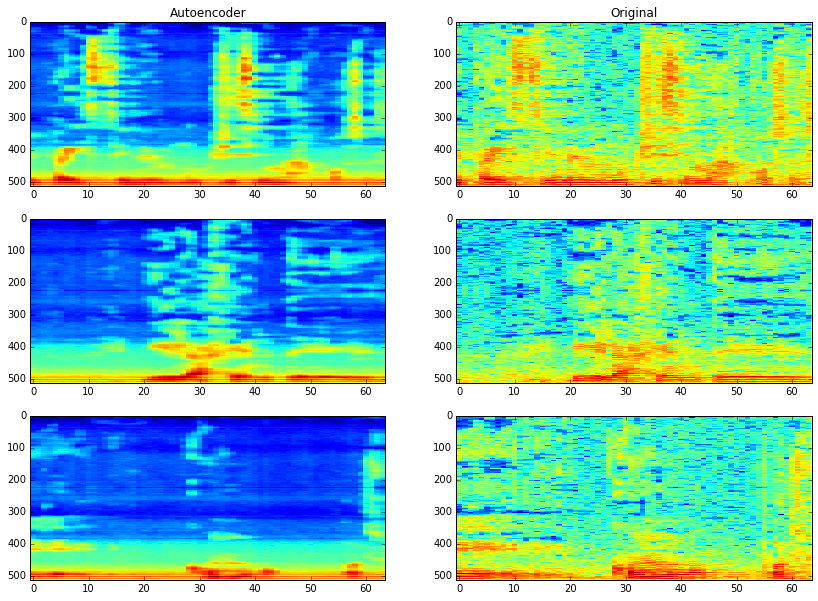

In [15]:
original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape(freq_bins,time_bins)+mean_img.reshape(freq_bins,time_bins),aspect='auto',interpolation='none')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',interpolation='none')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

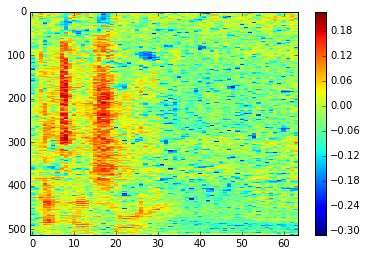

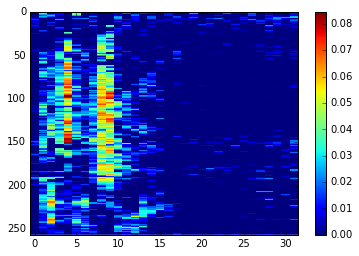

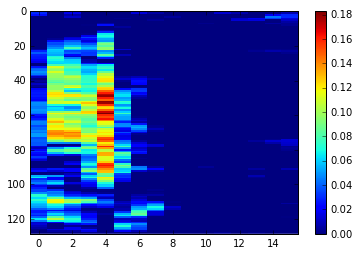

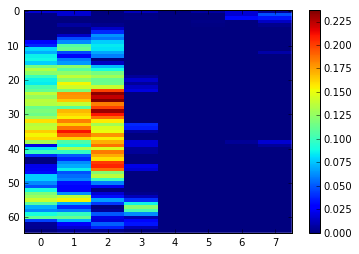

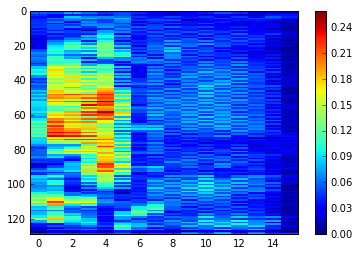

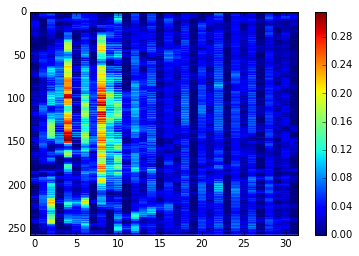

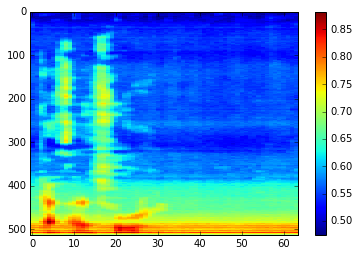

In [16]:
for l_ in l:
    recon = sess.run(l_, feed_dict={ ae['X']: data.data[28:29]-mean_img})
    figure()
    
    if l_==l[-1]:
        out = recon[0,:,:,0]+mean_img.reshape(freq_bins,time_bins)
    else:
        out = recon[0,:,:,0]
    imshow(out,aspect='auto',interpolation='none')
    
    colorbar()

In [13]:
cost = sess.run(ae['cost'], feed_dict={ae['X']: test.data-mean_img})